## Trade History model pre-training


This notebooks implements and pre-trains the trade history model on training data

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt

from data_preparation import process_data  

from lightgbm import LGBMRegressor
import lightgbm


from IPython.display import display, HTML

Setting the seed for layer initializer

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting up the credentials for GCP

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../eng-reactor-287421-112eb767e1b3.json"

Dataset threading on GPU

In [4]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

Initializing the big query client

In [5]:
bq_client = bigquery.Client()

Checking if GPU is available

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model

The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT_RATE = 0.01
NUM_HEADS = 25
TIME2VEC_DIMENSION = 10
FF_DIM = 200

SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

### Query to fetch data from BigQuery

The SQL query uses the trade history for training data view. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds which have a rating available and the yield is a positive number less than three.  


In [8]:
DATA_QUERY = """ SELECT
  *
FROM
  `eng-reactor-287421.primary_views.trade_history_for_training`
WHERE
  yield IS NOT NULL
  AND yield > 0 
  AND yield <= 3 
  AND par_traded IS NOT NULL
  AND sp_long IS NOT NULL
  AND sp_long != "NR"
  AND trade_date >= '2021-03-01' 
  AND trade_date <= '2021-06-01'
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_date DESC
            """

### Data Preparation

We grab the data from BigQuery and convert it into a format suitable for input to the model. The process_data function uses the big query functionality to return the data from the SQL query as a dataframe.

In [9]:
%%time
reference_data = process_data(DATA_QUERY, 
                              bq_client,
                              SEQUENCE_LENGTH,
                              NUM_FEATURES,
                              TRAIN_TEST_SPLIT,
                              'big_data.pkl')

Reading from file
File read
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negati

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,MSRB_maturity_date,msrb_cusip,yield_spread,num_prev_messages,MSRB_INST_ORDR_DESC,...,purpose_class,purpose_sub_class,sp_long,sp_stand_alone,sp_icr_school,sp_prelim_long,sp_outlook_long,sp_watch_long,assumed_redemption_date,trade_history
0,2021060104490300,2021-06-01 13:55:02,442331XS8,103.576,0.000,2022-03-01,442331XS8,-0.885653,0,1,...,19.0,NaN,AA,None,None,None,STABLE,None,2022-03-01,"[[-68.932044405124, 5.0, 0.0, 1.0, 14.89609871..."
1,2021060100719100,2021-06-01 10:01:45,1663936U7,122.701,0.000,2029-01-01,1663936U7,-0.248653,0,1,...,37.0,51.0,AAA,None,None,None,STABLE,None,2027-01-01,"[[-73.679754241717, 2370.0, 0.0, 1.0, 16.56511..."
2,2021060105522300,2021-06-01 14:51:09,505480K77,105.347,0.002,2030-09-15,505480K77,0.254347,0,1,...,19.0,NaN,AA,A,None,None,STABLE,NM,2024-09-15,"[[4.881314511048007, 10.0, 0.0, 1.0, 16.020369..."
3,2021060103553400,2021-06-01 13:05:37,097464XQ9,112.550,0.000,2024-04-01,097464XQ9,-0.552653,0,1,...,9.0,87.0,A+,None,None,None,STABLE,None,2024-04-01,"[[-39.830910948887, 10.0, 1.0, 0.0, 12.9775179..."
4,2021060106908000,2021-06-01 16:17:38,271664DQ4,102.593,0.000,2022-05-01,271664DQ4,-0.924653,0,1,...,37.0,11.0,AA,None,A,None,NEGATIVE,None,2022-05-01,"[[-77.56528420286999, 100.0, 1.0, 0.0, 7.49164..."


CPU times: user 13min 33s, sys: 31 s, total: 14min 4s
Wall time: 14min 3s


In [10]:
df = reference_data.copy()

In [11]:
df = df[df.par_traded > 10000]
df.yield_spread *= 100
print(len(df))

1073518


In [12]:
IDENTIFIERS = ['rtrs_control_number', 'cusip']
TRADE_HISTORY = ['trade_history']
TARGET = ['yield_spread']

PREDICTORS = TARGET + TRADE_HISTORY

In [13]:
processed_data = df[IDENTIFIERS + PREDICTORS]

Splitting the date into train and test set

In [14]:
processed_data

,rtrs_control_number,cusip,yield_spread,trade_history
0,2021060104490300,442331XS8,-88.565284,"[[-68.932044405124, 5.0, 0.0, 1.0, 14.89609871..."
1,2021060100719100,1663936U7,-24.865284,"[[-73.679754241717, 2370.0, 0.0, 1.0, 16.56511..."
2,2021060105522300,505480K77,25.434716,"[[4.881314511048007, 10.0, 0.0, 1.0, 16.020369..."
4,2021060106908000,271664DQ4,-92.465284,"[[-77.56528420286999, 100.0, 1.0, 0.0, 7.49164..."
6,2021060102705500,45470RCX2,-7.665284,"[[-2.1316099302860048, 25.0, 0.0, 0.0, 13.1567..."
...,...,...,...,...
1516323,2021030103945200,341271AE4,13.575787,"[[14.77578669699502, 4928.0, 0.0, 0.0, 5.26269..."
1516324,2021030108478700,914455QM5,-65.924213,"[[-62.824213303004996, 50.0, 1.0, 0.0, 9.03037..."
1516326,2021030108234900,20715CAS6,68.275787,"[[97.27578669699501, 25.0, 0.0, 0.0, 8.3332703..."
1516327,2021030102658200,97705MKQ7,-50.924213,"[[-57.53627628434701, 440.0, 1.0, 0.0, 14.3078..."


In [15]:
train_index = int( len(processed_data) * (1-TRAIN_TEST_SPLIT))
train_dataframe = processed_data[train_index:]
test_dataframe = processed_data[:train_index]

print(len(train_dataframe))
print(len(test_dataframe))


912491
161027


### Trade History Model

The trade history model uses the trade history to predict the yield spreads. The trade histories are processed by a LSTM.

In [26]:
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

lstm_layer = layers.LSTM(50, 
                   activation='tanh',
                   input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                   kernel_initializer = layer_initializer,
                   return_sequences = True,
                        name='LSTM')

lstm_layer_2 = layers.LSTM(100, 
                   activation='tanh',
                   input_shape=(SEQUENCE_LENGTH,50),
                   kernel_initializer = layer_initializer,
                   return_sequences = False,
                        name='LSTM_2')

features = lstm_layer(trade_history_input)
features = lstm_layer_2(features)

trade_history_output = layers.Dense(100,
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)


final = layers.Dense(1,
                     kernel_initializer=layer_initializer)(trade_history_output)


model = keras.Model(inputs=trade_history_input, outputs=final)

In [27]:
def create_input(df):
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    for f in NON_CAT_FEATURES + BINARY:
        datalist.append(df[f].to_numpy().astype('float64'))
        
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float64'))
    return datalist

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trade_history_input (InputLa [(None, 5, 5)]            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 5, 50)             11200     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


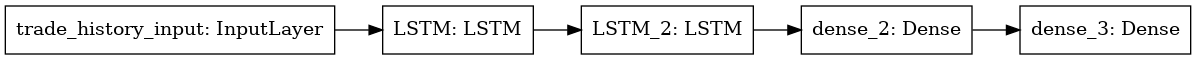

In [29]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [30]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [31]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 10,
                                                 profile_batch = '500,520')

In [32]:
train_data = np.stack(train_dataframe.trade_history.to_numpy())
%time history = model.fit(train_data, train_dataframe.yield_spread, epochs=30, batch_size=1000, verbose=1, validation_split=0.1, callbacks = [tboard_callback])

Epoch 1/30
822/822 [==============================] - 8s 7ms/step - loss: 787.9062 - mean_absolute_error: 18.4188 - val_loss: 612.1841 - val_mean_absolute_error: 17.3063
Epoch 2/30
822/822 [==============================] - 4s 4ms/step - loss: 534.4276 - mean_absolute_error: 15.1625 - val_loss: 593.1710 - val_mean_absolute_error: 17.0457
Epoch 3/30
822/822 [==============================] - 4s 4ms/step - loss: 520.4763 - mean_absolute_error: 14.8740 - val_loss: 602.7533 - val_mean_absolute_error: 17.0930
Epoch 4/30
822/822 [==============================] - 4s 4ms/step - loss: 509.6967 - mean_absolute_error: 14.6480 - val_loss: 560.4833 - val_mean_absolute_error: 16.1071
Epoch 5/30
822/822 [==============================] - 4s 4ms/step - loss: 504.6239 - mean_absolute_error: 14.5437 - val_loss: 583.8406 - val_mean_absolute_error: 16.7200
Epoch 6/30
822/822 [==============================] - 4s 4ms/step - loss: 496.2453 - mean_absolute_error: 14.3787 - val_loss: 548.0922 - val_mean_abso

In [33]:
test_data = np.stack(test_dataframe.trade_history.to_numpy())
_, mae = model.evaluate(test_data, test_dataframe.yield_spread, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

5033/5033 [==============================] - 10s 2ms/step - loss: 457.2875 - mean_absolute_error: 13.0187
Test MAE: 13.019


In [34]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

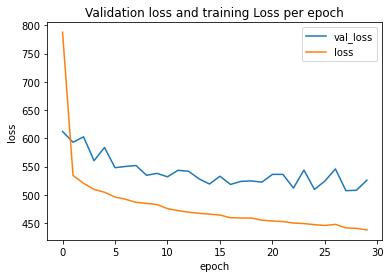

In [35]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [36]:
model.save('trade_history/')